# Machine Learning on TED Talk Dataset
* Use TED Talk transcripts as input, and use ratings and training labels. 
* Multilabel classification approach

## Import Libraries

In [269]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Reshape, Bidirectional
from tensorflow.keras import backend as K

from tqdm import tqdm 

import gensim.downloader as api

import string
import json 
import re

## Import Dataset

In [2]:
main_filepath = './ted_main.csv'
transcript_filepath = './transcripts.csv'

In [3]:
main = pd.read_csv(main_filepath)
transcripts = pd.read_csv(transcript_filepath)

In [80]:
main.head()

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,url,views
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110
1,265,With the same humor and humanity he exuded in ...,977,TED2006,1140825600,43,Al Gore,Al Gore: Averting the climate crisis,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...","[{'id': 243, 'hero': 'https://pe.tedcdn.com/im...",Climate advocate,"['alternative energy', 'cars', 'climate change...",Averting the climate crisis,https://www.ted.com/talks/al_gore_on_averting_...,3200520
2,124,New York Times columnist David Pogue takes aim...,1286,TED2006,1140739200,26,David Pogue,David Pogue: Simplicity sells,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 964}, {'i...","[{'id': 1725, 'hero': 'https://pe.tedcdn.com/i...",Technology columnist,"['computers', 'entertainment', 'interface desi...",Simplicity sells,https://www.ted.com/talks/david_pogue_says_sim...,1636292
3,200,"In an emotionally charged talk, MacArthur-winn...",1116,TED2006,1140912000,35,Majora Carter,Majora Carter: Greening the ghetto,1,1151367060,"[{'id': 3, 'name': 'Courageous', 'count': 760}...","[{'id': 1041, 'hero': 'https://pe.tedcdn.com/i...",Activist for environmental justice,"['MacArthur grant', 'activism', 'business', 'c...",Greening the ghetto,https://www.ted.com/talks/majora_carter_s_tale...,1697550
4,593,You've never seen data presented like this. Wi...,1190,TED2006,1140566400,48,Hans Rosling,Hans Rosling: The best stats you've ever seen,1,1151440680,"[{'id': 9, 'name': 'Ingenious', 'count': 3202}...","[{'id': 2056, 'hero': 'https://pe.tedcdn.com/i...",Global health expert; data visionary,"['Africa', 'Asia', 'Google', 'demo', 'economic...",The best stats you've ever seen,https://www.ted.com/talks/hans_rosling_shows_t...,12005869


In [81]:
transcripts.head()

,transcript,url
0,Good morning. How are you?(Laughter)It's been ...,https://www.ted.com/talks/ken_robinson_says_sc...
1,"Thank you so much, Chris. And it's truly a gre...",https://www.ted.com/talks/al_gore_on_averting_...
2,"(Music: ""The Sound of Silence,"" Simon & Garfun...",https://www.ted.com/talks/david_pogue_says_sim...
3,If you're here today — and I'm very happy that...,https://www.ted.com/talks/majora_carter_s_tale...
4,"About 10 years ago, I took on the task to teac...",https://www.ted.com/talks/hans_rosling_shows_t...


In [85]:
# merge datasets with 'inner join' on urls
dataset = pd.merge(left=main, right=transcripts, left_on='url', right_on='url')

## Analyze Main Dataset Features
* Length of dataset
* Number of Columns

In [88]:
# dataset.head()

In [89]:
columns = dataset.columns

In [90]:
new_columns = ['transcript', 'ratings', 'comments', 'duration', 'name', 'url']
new_dataset = dataset[new_columns]

In [91]:
new_dataset.head()

,transcript,ratings,comments,duration,name,url
0,Good morning. How are you?(Laughter)It's been ...,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...",4553,1164,Ken Robinson: Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...
1,"Thank you so much, Chris. And it's truly a gre...","[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...",265,977,Al Gore: Averting the climate crisis,https://www.ted.com/talks/al_gore_on_averting_...
2,"(Music: ""The Sound of Silence,"" Simon & Garfun...","[{'id': 7, 'name': 'Funny', 'count': 964}, {'i...",124,1286,David Pogue: Simplicity sells,https://www.ted.com/talks/david_pogue_says_sim...
3,If you're here today — and I'm very happy that...,"[{'id': 3, 'name': 'Courageous', 'count': 760}...",200,1116,Majora Carter: Greening the ghetto,https://www.ted.com/talks/majora_carter_s_tale...
4,"About 10 years ago, I took on the task to teac...","[{'id': 9, 'name': 'Ingenious', 'count': 3202}...",593,1190,Hans Rosling: The best stats you've ever seen,https://www.ted.com/talks/hans_rosling_shows_t...


In [452]:
print(new_dataset['transcript'][0])

Good morning. How are you?(Laughter)It's been great, hasn't it? I've been blown away by the whole thing. In fact, I'm leaving.(Laughter)There have been three themes running through the conference which are relevant to what I want to talk about. One is the extraordinary evidence of human creativity in all of the presentations that we've had and in all of the people here. Just the variety of it and the range of it. The second is that it's put us in a place where we have no idea what's going to happen, in terms of the future. No idea how this may play out.I have an interest in education. Actually, what I find is everybody has an interest in education. Don't you? I find this very interesting. If you're at a dinner party, and you say you work in education — Actually, you're not often at dinner parties, frankly.(Laughter)If you work in education, you're not asked.(Laughter)And you're never asked back, curiously. That's strange to me. But if you are, and you say to somebody, you know, they sa

In [92]:
print('Number of TED Talks: ', len(new_dataset))

Number of TED Talks:  2467


## Dataset Preprocessing

### Transcript Cleaning

In [240]:
# Transcript cleaning

'''
Remove punctuation from a `transcript` string
'''
def clean(transcript): 
    cleaned = transcript.translate(str.maketrans('', '', string.punctuation))
    
    # Temporarily remove `Laughter` from the transcript, but could be used later
    cleaned = cleaned.replace('Laughter', '')
    cleaned = cleaned.replace('Applause', '')
    
    # Remove hyphens 
    cleaned = cleaned.replace('—', '')
    
    # turn all characters into lowercase
    return cleaned

In [241]:
X = clean_transcripts(new_dataset)

In [450]:
# print(X[0])

### Ratings Preprocessing

* Need to create a ground truth for each row. It can be a list of proportions for each specific label.
* Can use the top-3 labels and 1. 

In [256]:
'''
This function creates labels in list format for each raw rating list
input from the dataset. 

Provide threshold for binarizing labels. 
'''
def create_label(rating, threshold=75): 
    rating_list = rating.strip('][').split('}, ') # Converting string to list 
    new_rating_list = []
    for cat in rating_list: 
        if cat[-1] != '}': 
            cat += '}'
        cat = cat.replace("'", '"')
        res = json.loads(cat)
        
        new_rating_list.append(res)
    new_rating_list.sort(key = lambda x: x['id'])
    
    rating_list = []
    for rating in new_rating_list: 
        rating_list.append(rating['count'])
        
    percentile = np.percentile(rating_list, 75)
    rating_list = [1 if i >= percentile else 0 for i in rating_list]
    return rating_list

### Create Preliminary Datasets and Labels

In [257]:
'''
For each row in the dataset, create the dataset (transcripts), and 
the corresponding arrays of labels for multi-label classification. 
'''
def create_xy(dataset): 
    X = []
    y = []
    for index, ted_talk in dataset.iterrows(): 
        # Transcript Preprocessing
        transcript = ted_talk[0]
        clean_script = clean(transcript)
        X.append(clean_script)
        
        # Rating Preprocessing
        rating = ted_talk[1]
        rating_list = create_label(rating)
        y.append(rating_list)
    return X, y

In [258]:
X, y = create_xy(new_dataset)

In [237]:
y = create_labels(clean_dataset)

In [260]:
print(y[:2])

[[0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0], [0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0]]


## Word Embeddings
* Represent each transcript as a 300-vector

In [108]:
wv = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [276]:
unidentified = []
identified = []
for x in tqdm(X): 
    words = x.split()
    for word in words: 
        try: 
            wv[word] # Outputs a 300-vector for each word
            identified.append(wv[word])
        except: 
            unidentified.append(word)

100%|█████████████████████████████████████████████████████████████████████████████| 2467/2467 [00:12<00:00, 194.53it/s]


In [275]:
print('Percent words unidentified: ', len(unidentified) * 100 /  (len(identified) + len(unidentified)))

Percent words unidentified:  12.752079193346582


In [384]:
def create_prediction_dataset(X, y):
    X_dset = []
    y_dset = []
    # for each transcript and label
    for tpt, lbl in tqdm(zip(X, y)):
        found_words = []
        words = tpt.split()
        for word in words: 
            try:
                found_words.append(wv[word])
            except: 
                continue
                
        embedding = np.asarray(found_words)
        mean = np.mean(embedding, axis=0)
        mean = mean.tolist()
        
#         print(len(mean))
#         print(mean.shape)
#         print(type(mean))
        if type(mean) == list: 
            X_dset.append(mean)
            y_dset.append(lbl)
    
    X_dset = np.asarray(X_dset)
    y_dset = np.array(y_dset)
    return X_dset, y_dset

In [385]:
X_dset, y_dset = create_prediction_dataset(X, y)

2467it [00:13, 178.62it/s]


In [370]:
for X, y in zip(X_dset, y_dset): 
    try: 
        if len(x) != 300: 
            print(len(x))
    except: 
        print(x)

In [386]:
# X_dset = X_dset.reshape((X_dset.shape[0], X_dset[0].shape[0]))

print('X_dset shape: ', X_dset.shape)
print('y_dset shape: ', y_dset.shape)

X_dset shape:  (2464, 300)
y_dset shape:  (2464, 14)


### Train-Test Split

In [387]:
def split_dataset(X_dset, y_dset, val_size=0.15, test_size=0.15): 
    X_train, X_test, y_train, y_test = train_test_split(
        X_dset, y_dset, test_size=test_size, random_state=42
    )
    
    print('X_train shape: ', X_train.shape)
    print('y_train shape: ', y_train.shape)
    
    print('X_test shape: ', X_test.shape)
    print('y_test shape: ', y_test.shape)
    return X_train, X_test, y_train, y_test

def create_dsets(X_train, X_test, y_train, y_test, batch_size=8): 
    train_dset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
    test_dset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)
    return train_dset, test_dset

In [388]:
X_train, X_test, y_train, y_test = split_dataset(X_dset, y_dset)
train_dset, test_dset = create_dsets(X_train, X_test, y_train, y_test)

X_train shape:  (2094, 300)
y_train shape:  (2094, 14)
X_test shape:  (370, 300)
y_test shape:  (370, 14)


## Deep Learning Model 

### Hyperparameters

In [410]:
HIDDEN_UNITS = 128
EPOCHS = 25

In [433]:
def create_model(hidden_units): 
    model = tf.keras.Sequential()
    input_layer = tf.keras.layers.Input(shape=(300,))
    hidden_layer_1 = tf.keras.layers.Dense(hidden_units, activation='relu')
    hidden_layer_2 = tf.keras.layers.Dense(hidden_units, activation='relu')
    # hidden_layer_3 = tf.keras.layers.Dense(hidden_units/2, activation='relu')
    output_layer = tf.keras.layers.Dense(14, activation='sigmoid')
    model.add(input_layer)
    model.add(hidden_layer_1)
    model.add(hidden_layer_2)
    # model.add(hidden_layer_3)
    model.add(output_layer)
    model.compile(optimizer='adam', loss='binary_crossentropy', 
                  metrics=['binary_accuracy', tf.keras.metrics.top_k_categorical_accuracy])
    model.summary()
    return model

model = create_model(HIDDEN_UNITS)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 128)               38528     
_________________________________________________________________
dense_16 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_17 (Dense)             (None, 14)                1806      
Total params: 56,846
Trainable params: 56,846
Non-trainable params: 0
_________________________________________________________________


In [434]:
def plot(p1, p2=None, title='Plot', x_label='', y_label='', p1_legend=None, p2_legend=None): 
    plt.figure()
    plt.plot(range(len(p1)), p1, label=p1_legend)
    if p2 is not None: 
        plt.plot(range(len(p2)), p2, label=p2_legend)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.show()   

In [435]:
hist = model.fit(train_dset, validation_data=test_dset, epochs=EPOCHS)

Epoch 1/25
262/262 [==============================] - 1s 2ms/step - loss: 0.4848 - binary_accuracy: 0.7961 - top_k_categorical_accuracy: 0.5302 - val_loss: 0.4077 - val_binary_accuracy: 0.8236 - val_top_k_categorical_accuracy: 0.6541
Epoch 2/25
262/262 [==============================] - 0s 1ms/step - loss: 0.3758 - binary_accuracy: 0.8394 - top_k_categorical_accuracy: 0.7108 - val_loss: 0.3589 - val_binary_accuracy: 0.8533 - val_top_k_categorical_accuracy: 0.7676
Epoch 3/25
262/262 [==============================] - 0s 1ms/step - loss: 0.3340 - binary_accuracy: 0.8610 - top_k_categorical_accuracy: 0.7991 - val_loss: 0.3492 - val_binary_accuracy: 0.8517 - val_top_k_categorical_accuracy: 0.7811
Epoch 4/25
262/262 [==============================] - 0s 1ms/step - loss: 0.3247 - binary_accuracy: 0.8652 - top_k_categorical_accuracy: 0.8206 - val_loss: 0.3427 - val_binary_accuracy: 0.8539 - val_top_k_categorical_accuracy: 0.8027
Epoch 5/25
262/262 [==============================] - 0s 1ms/ste

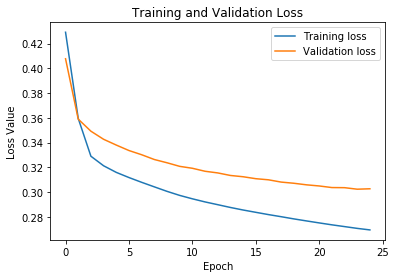

In [436]:
plot(hist.history['loss'], p2=hist.history['val_loss'], 
             title='Training and Validation Loss', x_label='Epoch', y_label='Loss Value', 
            p1_legend='Training loss', p2_legend='Validation loss')

### Model Save

In [445]:
model_filepath = './ted_analysis_model'
model.save(model_filepath)

INFO:tensorflow:Assets written to: ./ted_analysis_model\assets


### Model Evaluation

In [437]:
y_pred = model.predict(test_dset)

In [438]:
# todo: have to graph to compare
y_pred[0]

array([0.8419161 , 0.00223282, 0.31465387, 0.2858566 , 0.25100094,
       0.06098631, 0.97904253, 0.01943737, 0.03248349, 0.59948593,
       0.06064478, 0.2695647 , 0.13989949, 0.02260396], dtype=float32)

In [439]:
y_test[0]

array([1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0])

<BarContainer object of 14 artists>

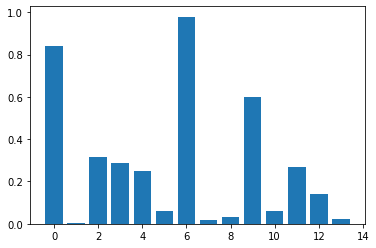

In [440]:
plt.bar(range(14), y_pred[0])

In [441]:
def plot_probs(pred, true): 
    one_indices = []
    zero_indices = []
    for index, i in enumerate(true): 
        if i == 1: 
            one_indices.append(index)
        else: 
            zero_indices.append(index)
    plt.figure()
    plt.bar(zero_indices, pred[zero_indices], color='blue')
    plt.bar(one_indices, pred[one_indices], color='red')
    plt.plot()

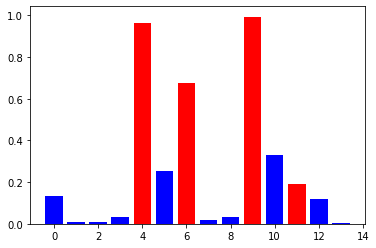

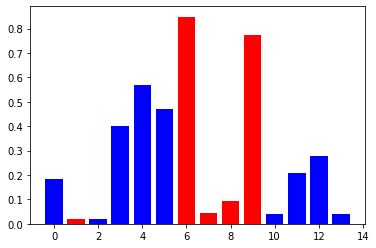

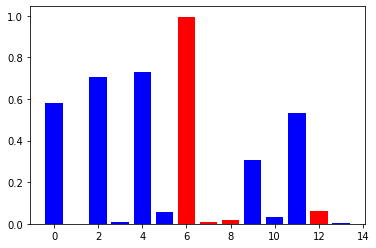

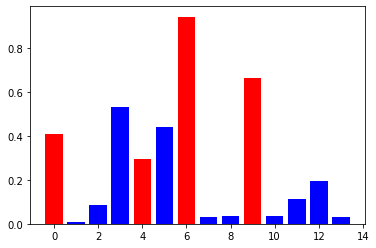

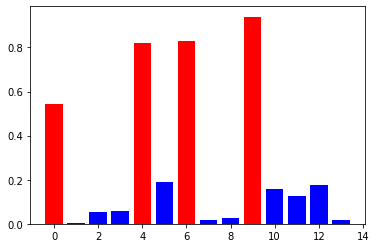

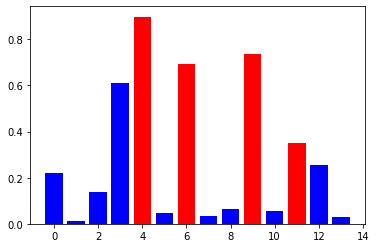

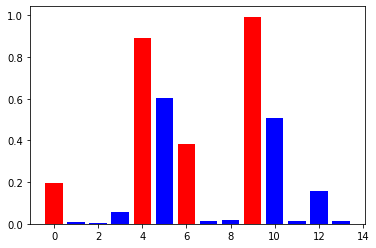

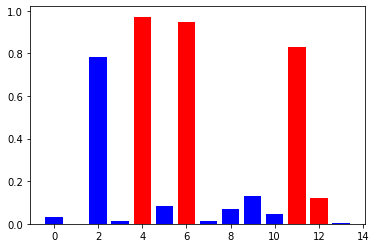

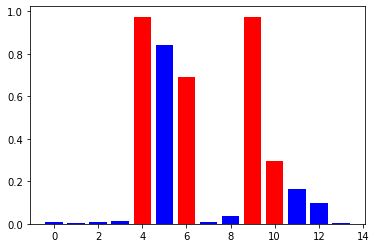

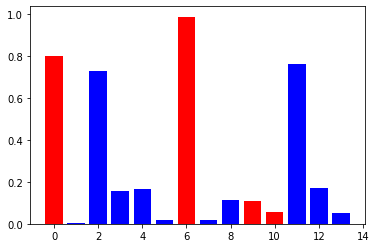

In [444]:
# Visualize random subset of transcripts performance
for i in range(20, 30): 
    plot_probs(y_pred[i], y_test[i])    